<a target="_blank" href="https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/bigquery-integrated-earth-data/01-BigQuery%2BEarth-Engine.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
#@title Copyright 2025 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title Install Dependencies

!pip install mapclassify xyzservices

import ee

import numpy as np
import pandas as pd
import geopandas as gpd

import folium
import mapclassify
import xyzservices

tiles =  xyzservices.TileProvider.from_qms("Google Satellite Hybrid")

### 1. Authenticate and Initialize EE and BQ

In [ ]:
project_id = 'cloud-geographers-internal-gee' # Change to a project where you have EE access.
ee.Authenticate()
ee.Initialize(project=project_id)

### 2. Create a GeoDataFrame of Republic of the Congo Départements

This data comes from the [Overture Maps data in BigQuery's Public Data Catalog](https://https://carto.com/blog/overture-maps-data-now-on-the-cloud-use-it-with-carto) which is maintained by Google's partner, [Carto](https://carto.com/)

In [ ]:
query = """ SELECT * FROM `bigquery-public-data.overture_maps.division_area` where country = 'CG' and subtype = 'region' """

# Use the BQ client to retrieve the Republic of the Congo Départements into a Pandas DataFrame
congo = pd.read_gbq(query,project_id=project_id)

# Convert the DataFrame to a GeoDataFrame, using the geometry column
congo = gpd.GeoDataFrame(congo, geometry=gpd.GeoSeries.from_wkt(congo.geometry), crs='epsg:4326')


In [ ]:
m = congo.explore(tiles=tiles, attr="Google Maps", name='Congo Départements')
m

### 2. Select the Earth Engine Data with which we wish to enrich the Départements' geographies.


For this analysis, we're going to use the [ESA WorldCover](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200#bands) data which is a global 10m landcover dataset. Specifically, we'll look at the "tree cover" class.

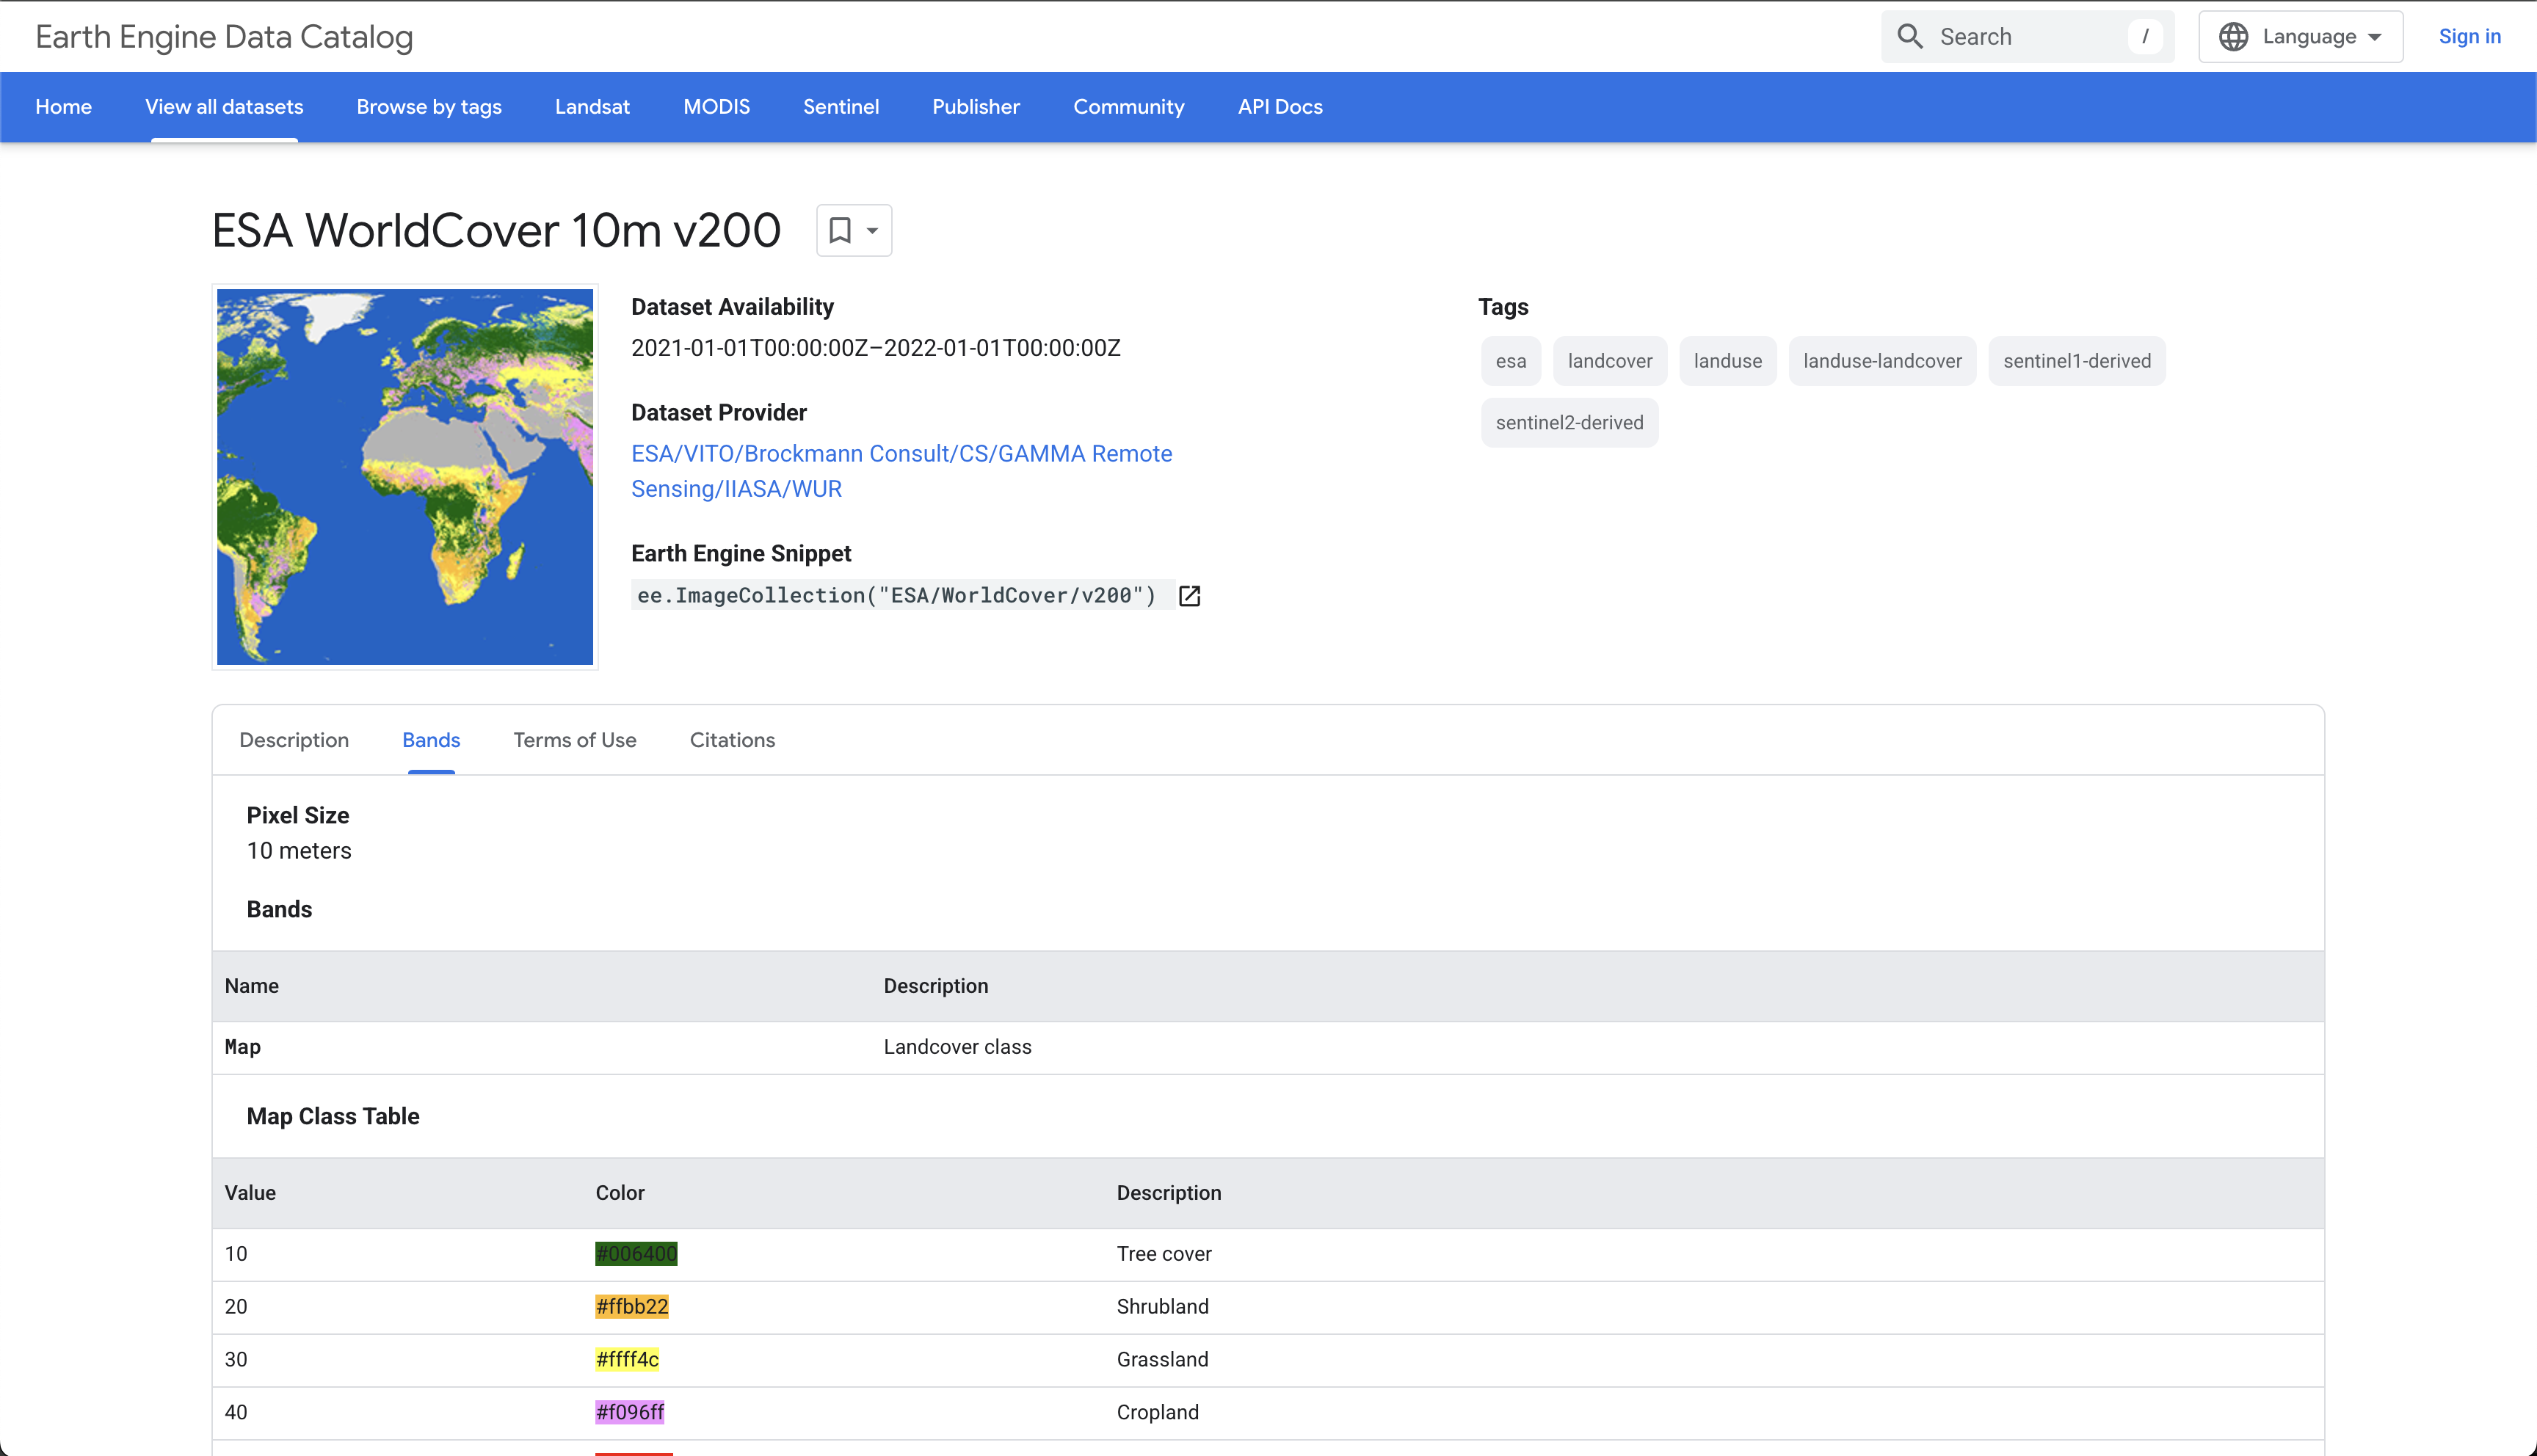

In [ ]:
# Create a server-side Earth Engine image by selecting the year 2021
image = ee.Image("ESA/WorldCover/v200/2021")

# Visualize this image and add it to the notebook map.
mapID = image.getMapId()

# Get the Z/X/Y Tile URL pattern of the image.
WorldCover_Tiles = mapID['tile_fetcher'].url_format

# Create a new tile layer from the EE image and add it to the map.
folium.TileLayer(
    tiles=WorldCover_Tiles,
    attr='ESA WorldCover 10m 2021',
    name='ESA WorldCover',
    overlay=True,
    opacity=.6,
    control=True,
    show=True
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

m

In [ ]:
# Create an Earth Engine FeatureCollection from the GeoDataFrame
# This will loop over the entire geodataframe and recreate the geometries
# as features in a new Earth Engine FeatureCollection server-side.

def get_ee_feature(geom):
    x,y = geom.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    g = ee.Geometry.Polygon(coords)
    return ee.Feature(g)

features = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in congo.iterrows()])

# Create a selection of the WorldCover image which is just the "tree cover" class

forest = image.eq(10)

## 3. Reduce a statistic of the image for each geometry in Earth Engine and return a GeoDataFrame

In [ ]:
# Define a simple Earth Engine expression which will return the mean forest
# coverage % for each geometry in the FeatureCollection

congo_mean_forest = forest.reduceRegions(
    collection=features,
    reducer=ee.Reducer.mean(),
    scale=1e3
)

# Use EE Data Converter for computeFeatures to return a GeoPandas GeoDataFrame

congo_mean_forest_gdf = ee.data.computeFeatures({
    'expression': congo_mean_forest,
    'fileFormat': 'GEOPANDAS_GEODATAFRAME'
})
# Specify the coordinate reference system
congo_mean_forest_gdf.crs = 'EPSG:4326'

In [ ]:
# Display a chloropleth map of Mean Forested % for each Congo Département

m = congo_mean_forest_gdf.explore(
    "mean",
    cmap="RdYlGn",
    scheme="NaturalBreaks",
    tooltip=["mean"],
    tiles=tiles,
    attr="Google Maps",
    name="Mean Forested %")
folium.TileLayer(
    tiles=WorldCover_Tiles,
    attr='ESA WorldCover 10m 2021',
    name='ESA WorldCover',
    overlay=True,
    opacity=.1,
    control=True,
    show=True
).add_to(m)

# Add a layer control
folium.LayerControl().add_to(m)

m